In 2019, Frances Krsinich and Donal Lynch of StatsNZ (working with Harpal Shergill of UNSD) published a synthetic scanner dataset that could be used for various types of research topics, including on multilateral and for quality adjustment methods. The dataset is hosted on the [UN Global Platform GitLab](https://code.officialstatistics.org/scanner-task-team-gwg/FEWS_package/-/blob/master/data/SampleDataSet.csv?ref_type=heads) and is provided for researchers. 

This short blog is a short exploration of the dataset to better understand it.

::: {.callout-tip}
## Reproduce this blog

This blog is a jupyter article under the hood - have a look at the source. Save a copy of the data to `/data/bronze/` and re-render.
:::

## Dataset structure

The data is tabular and it shows products sold per period with a large number of characteristics already pre-cleaned

In [70]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud

In [104]:
# Load dataset
df = pd.read_csv("../data/bronze/NZ_electronics_2019-02_raw.csv")

In [105]:
df.head()

,month_num,char11,char1,char2,char3,char4,char5,char6,char7,char8,char9,char10,prodid_num,quantity,value
0,2017-01-01,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,280,196420
1,2017-02-01,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,126,85312
2,2017-03-01,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,148,95920
3,2017-04-01,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,56,38552
4,2017-05-01,brand_a,10.6,16006,val_w,val_a,val_a,PRG566,CCC,150D,B230,ted,3,69,47397


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5509 entries, 0 to 5508
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month_num   5509 non-null   object 
 1   char11      5509 non-null   object 
 2   char1       5509 non-null   float64
 3   char2       5509 non-null   int64  
 4   char3       5509 non-null   object 
 5   char4       5509 non-null   object 
 6   char5       5509 non-null   object 
 7   char6       5509 non-null   object 
 8   char7       5509 non-null   object 
 9   char8       5509 non-null   object 
 10  char9       5509 non-null   object 
 11  char10      5509 non-null   object 
 12  prodid_num  5509 non-null   int64  
 13  quantity    5509 non-null   int64  
 14  value       5509 non-null   int64  
dtypes: float64(1), int64(4), object(10)
memory usage: 645.7+ KB


The key question is how to interpret all these feature columns and what the overall information is in the data

In [54]:
#| echo: true
#| code-fold: true

stats = {}
stats['Number of unique products (prodid_num column)'] = df['prodid_num'].nunique()
stats['Number of months in sample'] = df['month_num'].nunique()
stats['First month in sample'] = df['month_num'].min()
stats['Last month in sample'] = df['month_num'].max()
stats['Char11 unique count (brands)'] = df['char11'].nunique()
stats['Char1 unique count (possibly screen size)'] = df['char1'].nunique()
stats['Char10 unique count'] = df['char10'].nunique()

pd.DataFrame.from_dict(stats, orient='index', columns=['statistic'])

,statistic
Number of unique products (prodid_num column),459
Number of months in sample,26
First month in sample,2017-01-01
Last month in sample,2019-02-01
Char11 unique count (brands),10
Char1 unique count (possibly screen size),17
Char10 unique count,5


# Important nuances in the data

While it may not be explicit issues, there are some nuances to work through if you use it. Before using the data for price statistics, its important to consider these nuances

## Every period has some duplicated products

Every period has products that seem to be duplicated - i.e. products are identical in all but sale information. We can see this by comparing the number of unique products (if we use the `prodid_num` column) and comparing it with just a count of the same products (without de-duplication).

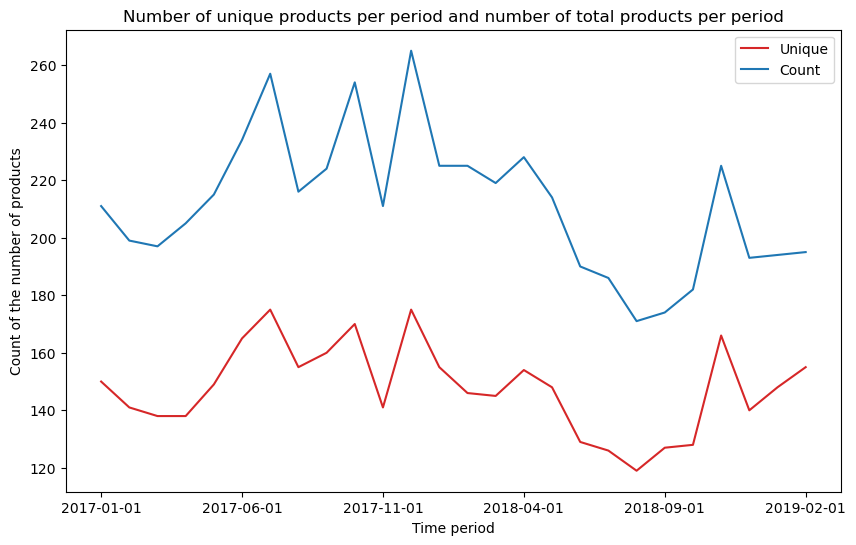

In [ ]:
#| echo: true
#| code-fold: true

series_unique = df.groupby(['month_num'])['prodid_num'].nunique()
series_count = df.groupby(['month_num'])['prodid_num'].count()

df2 = pd.DataFrame({'Unique': series_unique, 'Count': series_count})

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first series and store the Axes object
df2['Unique'].plot(ax=ax, label='Unique', color='tab:red')

# Plot the second series on the same Axes object
df2['Count'].plot(ax=ax, label='Count', color='tab:blue')

# Add labels, a title, and a legend
ax.set_xlabel('Time period')
ax.set_ylabel('Count of the number of products')
ax.set_title('Number of unique products per period and number of total products per period')
ax.legend()

# Display the plot
plt.show()

Looking at a few examples - it is clear that all product features are identical _except_ the `quanity` and the `value` counts

In [96]:
#| echo: true
#| code-fold: true

df_first_period.groupby(['prodid_num']).filter(lambda x: x['char11'].count() > 1).head(2)

,month_num,char11,char1,char2,char3,char4,char5,char6,char7,char8,char9,char10,prodid_num,quantity,value
88,2017-01-01,brand_a,10.6,3718,val_u,val_a,val_e,FBOK6552,AAA,100M,B230,cuy,12,46,16003
89,2017-01-01,brand_a,10.6,3718,val_u,val_a,val_e,FBOK6552,AAA,100M,B230,cuy,12,22,8503


Lets look at another example

In [ ]:
#| echo: true
#| code-fold: true

df_first_period.groupby(['prodid_num']).filter(lambda x: x['char11'].count() > 1).iloc[2:4]

,month_num,char11,char1,char2,char3,char4,char5,char6,char7,char8,char9,char10,prodid_num,quantity,value
503,2017-01-01,brand_a,15.0,7814,val_z,val_a,val_b,MG745,AAA,100M,B230,cuy,140,346,149104
504,2017-01-01,brand_a,15.0,7814,val_z,val_a,val_b,MG745,AAA,100M,B230,cuy,140,285,112033


And another

In [86]:
#| echo: true
#| code-fold: true

df_first_period.groupby(['prodid_num']).filter(lambda x: x['char11'].count() > 1).iloc[4:6]

,month_num,char11,char1,char2,char3,char4,char5,char6,char7,char8,char9,char10,prodid_num,quantity,value
540,2017-01-01,brand_a,16.6,16006,val_a,val_b,val_f,PRRAPU,CCC,100M,B230,ted,145,215,161386
541,2017-01-01,brand_a,16.6,16006,val_a,val_b,val_f,PRRAPU,CCC,100M,B230,ted,145,15,10212


While its unclear why this is the case -- to use the data it may be useful to do a groupby and sum `quantity` and `value` columns when calculating a unit price

# Product and price trends

## Average prices across time

Lets first consider an average price of each category

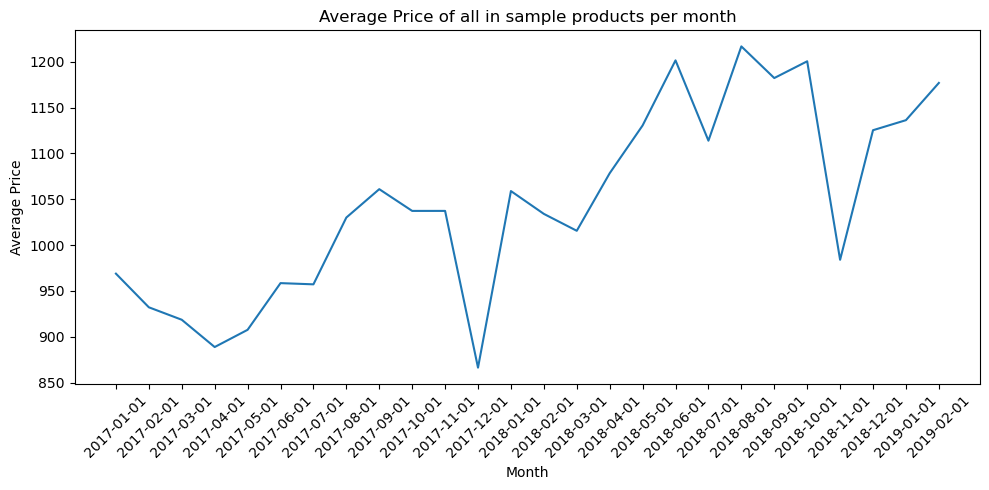

In [121]:
#| echo: true
#| code-fold: true

agg_dict = {
    'char11': 'first',
    'char1':'first',
    'char2':'first',
    'char3':'first',
    'char4':'first',
    'char5':'first',
    'char6':'first',
    'char7':'first',
    'char8':'first',
    'char9':'first',
    'char10':'first',
    'quantity':'sum',
    'value':'sum'
}

df_aggregated = df.groupby(['month_num','prodid_num']).agg(agg_dict)
df_aggregated['unit_price'] = df_aggregated['value']/df_aggregated['quantity']

price_trend = df_aggregated.groupby(["month_num"])["unit_price"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=price_trend, x="month_num", y="unit_price")
plt.title("Average Price of all in sample products per month")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()